In [1236]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import keras
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
import joblib
from IPython.display import Image  
from sklearn.tree import plot_tree
import xgboost as xgb
#Read the csv, drop index column
df=pd.read_csv("fraud_payment_data.csv")


In [1237]:
#Drop the rows with missing values
print("Number of total rows: ", len(df))
df = df.dropna()
print("Number of rows after dropping na: ", len(df))
df = df.drop(index=df[df['USD_amount'] == 0].index)
print("Number of rows after dropping USD_amount = 0: ", len(df))

df.info()
df.columns = df.columns.str.replace(' ', '_')

Number of total rows:  1498178
Number of rows after dropping na:  1063397
Number of rows after dropping USD_amount = 0:  1063375
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063375 entries, 1 to 1498177
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1063375 non-null  object 
 1   Transaction_Id    1063375 non-null  object 
 2   Sender_Id         1063375 non-null  object 
 3   Sender_Account    1063375 non-null  object 
 4   Sender_Country    1063375 non-null  object 
 5   Sender_Sector     1063375 non-null  float64
 6   Sender_lob        1063375 non-null  object 
 7   Bene_Id           1063375 non-null  object 
 8   Bene_Account      1063375 non-null  object 
 9   Bene_Country      1063375 non-null  object 
 10  USD_amount        1063375 non-null  float64
 11  Label             1063375 non-null  float64
 12  Transaction_Type  1063375 non-null  object 
dtypes: float64(3), obj

In [1238]:
# Agrupar el dataset por Sender_Account y contar el número de transacciones
num_transacciones = df.groupby("Sender_Account")["Transaction_Id"].agg(["count"])

# Renombrar la columna resultante para que se llame "Num_Transacciones"
num_transacciones = num_transacciones.rename(columns={"count": "Num_Transacciones"})
#print num_transacciones
num_transacciones.head()

,Num_Transacciones
Sender_Account,
ACCOUNT-100004,1
ACCOUNT-1000051,1
ACCOUNT-1000193,1
ACCOUNT-1000194,55
ACCOUNT-1000195,46


In [1239]:
# Agrupar el dataset por Sender_Account y encontrar el valor máximo de la columna "FLAG"
flag = df.groupby("Sender_Account")["Label"].agg(["max"])

# Convertir los valores máximos a 1 o 0
flag["max"] = flag["max"].apply(lambda x: 1 if x == 1 else 0)

# Renombrar la columna resultante para que se llame "FLAG"
flag = flag.rename(columns={"max": "Label"})

# Unir los datos con el dataset original
df_accounts = pd.merge(num_transacciones, flag, on="Sender_Account")
df_accounts.head()

,Num_Transacciones,Label
Sender_Account,,
ACCOUNT-100004,1,0
ACCOUNT-1000051,1,0
ACCOUNT-1000193,1,0
ACCOUNT-1000194,55,1
ACCOUNT-1000195,46,0


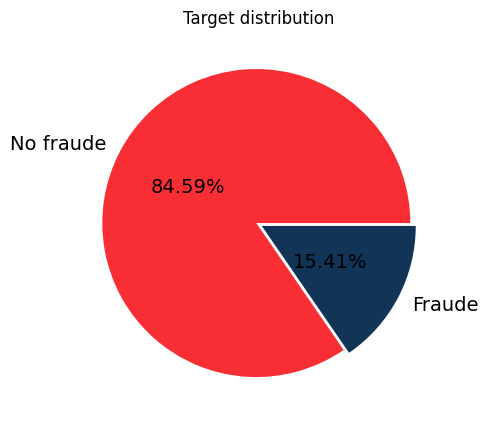

In [1240]:
#Recuento de cuantas cuentas tienen transacciones fraudulentas
df_accounts["Label"].value_counts()


pie, ax = plt.subplots(figsize=[7,5])
labels = ['No fraude', 'Fraude']
colors = ['#f92e35', '#123456']
plt.pie(x = df_accounts["Label"].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

In [1241]:
#muestra estadisticas de Num_Transacciones
df_accounts.describe()

,Num_Transacciones,Label
count,73999.000000,73999.000000
mean,14.370127,0.154083
std,16.597434,0.361031
min,1.000000,0.000000
25%,1.000000,0.000000
50%,8.000000,0.000000
75%,26.000000,0.000000
max,79.000000,1.000000


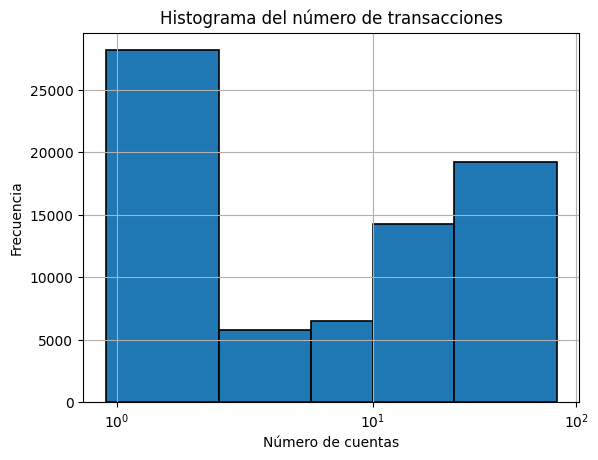

1        28193
25-80    18730
5-10     10806
10-25     9570
2-5       6700
Name: Num_Transacciones_discretized, dtype: int64

In [1242]:
#crea bin con 0,2,5,10,25,80
bins = [0.9, 1.9, 5, 10, 25, 80]
#muestra histograma del número de transacciones
plt.xscale('symlog')
df_accounts["Num_Transacciones"].hist(bins=bins,align='mid',edgecolor='black', linewidth=1.2)
plt.title('Histograma del número de transacciones')
plt.xlabel('Número de cuentas')
plt.ylabel('Frecuencia')
plt.show()
#crea una nueva columna discretizando en los bins de antes
df_accounts['Num_Transacciones_discretized'] = pd.cut(df_accounts['Num_Transacciones'], bins=bins, labels=['1', '2-5', '5-10', '10-25', '25-80'])
#muestra estadisticas de la nueva columna
df_accounts['Num_Transacciones_discretized'].value_counts()


In [1243]:
# Filtrar las filas que tienen Label=1
fraud = df[df["Label"] == 1]

# Agrupar el dataset filtrado por Sender_Account y encontrar el porcentaje de transacciones fraudulentas
perc_fraud = fraud.groupby("Sender_Account").agg({"Transaction_Id": "count", "Label": "sum"})
perc_fraud["Perc_Fraud"] = perc_fraud["Label"] / perc_fraud["Transaction_Id"]

# Renombrar la columna resultante para que se llame "Perc_Fraud"
perc_fraud = perc_fraud.rename(columns={"Perc_Fraud": "Perc_Fraud"})

# Unir los datos con el dataset original
df_accounts = pd.merge(df_accounts, perc_fraud, on="Sender_Account", how="left")

# Rellenar los valores NaN con 0
df_accounts["Perc_Fraud"] = df_accounts["Perc_Fraud"].fillna(0)
df_accounts.head(20)

,Num_Transacciones,Label_x,Num_Transacciones_discretized,Transaction_Id,Label_y,Perc_Fraud
Sender_Account,,,,,,
ACCOUNT-100004,1,0,1,NaN,NaN,0.0
ACCOUNT-1000051,1,0,1,NaN,NaN,0.0
ACCOUNT-1000193,1,0,1,NaN,NaN,0.0
ACCOUNT-1000194,55,1,25-80,1.0,1.0,1.0
ACCOUNT-1000195,46,0,25-80,NaN,NaN,0.0
ACCOUNT-1000196,9,0,5-10,NaN,NaN,0.0
ACCOUNT-1000198,1,0,1,NaN,NaN,0.0
ACCOUNT-1000199,21,1,10-25,1.0,1.0,1.0
ACCOUNT-1000200,1,0,1,NaN,NaN,0.0


In [1244]:
#Drop first column
#df = df.drop(df.columns[0], axis=1)
#print(df.columns)

categories = df.select_dtypes('O').columns.astype('category')
df[categories]

for i in df.columns:
    print(f'Column --{i}-- has --{len(df[i].value_counts())}-- unique values')

df.describe()

a=(df.Label==1).value_counts()
print(a)

Column --Time_step-- has --544719-- unique values
Column --Transaction_Id-- has --1063375-- unique values
Column --Sender_Id-- has --58423-- unique values
Column --Sender_Account-- has --73999-- unique values
Column --Sender_Country-- has --252-- unique values
Column --Sender_Sector-- has --50000-- unique values
Column --Sender_lob-- has --1-- unique values
Column --Bene_Id-- has --278068-- unique values
Column --Bene_Account-- has --293206-- unique values
Column --Bene_Country-- has --252-- unique values
Column --USD_amount-- has --100309-- unique values
Column --Label-- has --2-- unique values
Column --Transaction_Type-- has --4-- unique values
False    1041813
True       21562
Name: Label, dtype: int64


Central tendency

In [1245]:

categories = df.select_dtypes('O').columns.astype('category')
df[categories]


,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_lob,Bene_Id,Bene_Account,Bene_Country,Transaction_Type
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,QUICK-PAYMENT
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,PAY-CHECK
5,2022-03-15 10:24:00,PAY-CHECK-9780,JPMC-CLIENT-9763,ACCOUNT-9773,USA,CCB,JPMC-COMPANY-9765,ACCOUNT-9771,BELARUS,PAY-CHECK
10,2022-03-15 10:24:00,QUICK-PAYMENT-9249,JPMC-CLIENT-9229,ACCOUNT-9239,USA,CCB,COMPANY-9231,ACCOUNT-9237,QATAR,QUICK-PAYMENT
11,2022-03-15 10:24:00,MOVE-FUNDS-9246,JPMC-CLIENT-9229,ACCOUNT-9240,USA,CCB,CLIENT-9247,ACCOUNT-9248,TANZANIA,MOVE-FUNDS
...,...,...,...,...,...,...,...,...,...,...
1498173,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,MAKE-PAYMENT
1498174,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,QUICK-PAYMENT
1498175,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,MAKE-PAYMENT
1498176,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,QUICK-PAYMENT


In [1246]:
for i in df[categories].columns:
    print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()
large=df.nlargest(5, ['USD_amount'])
print(large)
df[numericals].var()


The categorical column --Time_step-- has --544719-- unique values
The categorical column --Transaction_Id-- has --1063375-- unique values
The categorical column --Sender_Id-- has --58423-- unique values
The categorical column --Sender_Account-- has --73999-- unique values
The categorical column --Sender_Country-- has --252-- unique values
The categorical column --Sender_lob-- has --1-- unique values
The categorical column --Bene_Id-- has --278068-- unique values
The categorical column --Bene_Account-- has --293206-- unique values
The categorical column --Bene_Country-- has --252-- unique values
The categorical column --Transaction_Type-- has --4-- unique values
                   Time_step         Transaction_Id           Sender_Id  \
284027   2028-05-03 15:44:38   QUICK-PAYMENT-415525       CLIENT-415368   
1137088  2046-12-06 05:06:36   MAKE-PAYMENT-1664525      CLIENT-1664521   
549956   2034-02-12 20:35:15       PAY-CHECK-801220  JPMC-CLIENT-801171   
1068317  2045-06-04 09:16:26  

Sender_Sector    2.082015e+08
USD_amount       2.983459e+05
Label            1.986581e-02
dtype: float64

In [1247]:
sorted_df = df.sort_values(by='USD_amount', ascending=False)
print(sorted_df.USD_amount)

284027     19927.99
1137088    19921.43
549956     19700.91
1068317    19699.39
542984     19629.81
             ...   
1096594        0.01
692555         0.01
229319         0.01
1266091        0.01
1472077        0.01
Name: USD_amount, Length: 1063375, dtype: float64


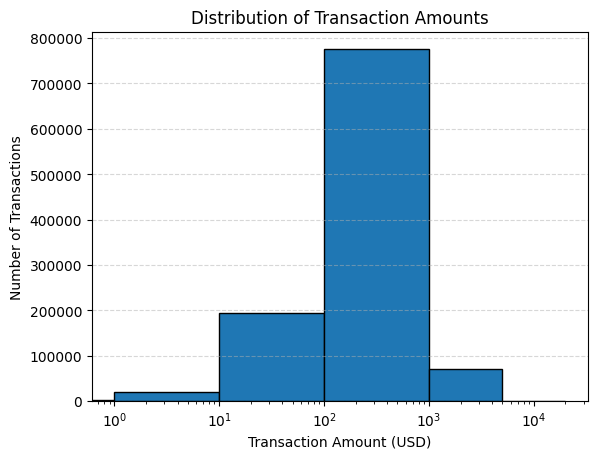

In [1248]:

# Define the bin edges
bins = [0,1,10, 100, 1000, 5000,20000]
df=df.dropna()
# Plot the histogram
plt.hist(df['USD_amount'], bins=bins, align='mid',edgecolor='black')
# Set the x-axis scale to 'log'
plt.xscale('log')
# Set the axis labels and title

plt.xlabel('Transaction Amount (USD)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transaction Amounts')
plt.grid(axis='y', alpha=0.5, linestyle='--')


plt.show()


Distribution by countries

In [1249]:
# Statistics of top 10 Sender_Country
df['Sender_Country'].value_counts().head(10)
#All values that is not 


USA               805481
GERMANY            73362
CANADA             27296
FRENCH-GUIANA        996
THAILAND             985
LIECHTENSTEIN        982
MAURITANIA           973
KUWAIT               941
JAMAICA              919
CAYMAN-ISLANDS       897
Name: Sender_Country, dtype: int64

In [1250]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def pais_a_continente(pais):
    try:
        # Casos especiales
        if pais == "USA":
            return "USA"
        if pais == "GERMANY":
            return "GERMANY"
        if pais == "CANADA":
            return "CANADA"
        
        # Removiendo guiones y convirtiendo a nombre normal
        pais = pais.replace('-', ' ').title()
        cn_a2_code = country_name_to_country_alpha2(pais)
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Desconocido'  # si el país no está en el paquete pycountry-convert
    return cn_continent

df['Sender_Country'] = df['Sender_Country'].apply(pais_a_continente)


df['Sender_Country'].value_counts().head(30)


USA            805481
GERMANY         73362
AS              32781
AF              32327
EU              28080
CANADA          27296
Desconocido     22455
NA              18198
OC              13131
SA               9465
AN                799
Name: Sender_Country, dtype: int64

In [1251]:
#Statistics only the fraud transactions
fraud=df[df['Label']==1]
fraud['Sender_Country'].value_counts().head(10)

USA            16691
CANADA           946
AF               822
AS               807
EU               682
Desconocido      559
NA               408
OC               346
SA               244
GERMANY           49
Name: Sender_Country, dtype: int64

In [1252]:
#Statistics of top 10 Bene_Country
df['Bene_Country'].value_counts().head(200)
#show all values  of Bene_Country


USA               563692
CANADA            134351
GERMANY             7886
CAYMAN-ISLANDS      1843
BRAZIL              1817
                   ...  
LITHUANIA           1308
PORTUGAL            1306
GRENADA             1300
GHANA               1299
NORWAY              1298
Name: Bene_Country, Length: 200, dtype: int64

In [1253]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def pais_a_continente(pais):
    try:
        # Casos especiales
        if pais == "USA":
            return "USA"
        if pais == "GERMANY":
            return "GERMANY"
        if pais == "CANADA":
            return "CANADA"
        
        # Removiendo guiones y convirtiendo a nombre normal
        pais = pais.replace('-', ' ').title()
        cn_a2_code = country_name_to_country_alpha2(pais)
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Desconocido'  # si el país no está en el paquete pycountry-convert
    return cn_continent

df['Bene_Country'] = df['Bene_Country'].apply(pais_a_continente)


df['Bene_Country'].value_counts().head(30)

USA            563692
CANADA         134351
AS              74111
AF              71963
EU              63341
Desconocido     52176
NA              41954
OC              30820
SA              21455
GERMANY          7886
AN               1626
Name: Bene_Country, dtype: int64

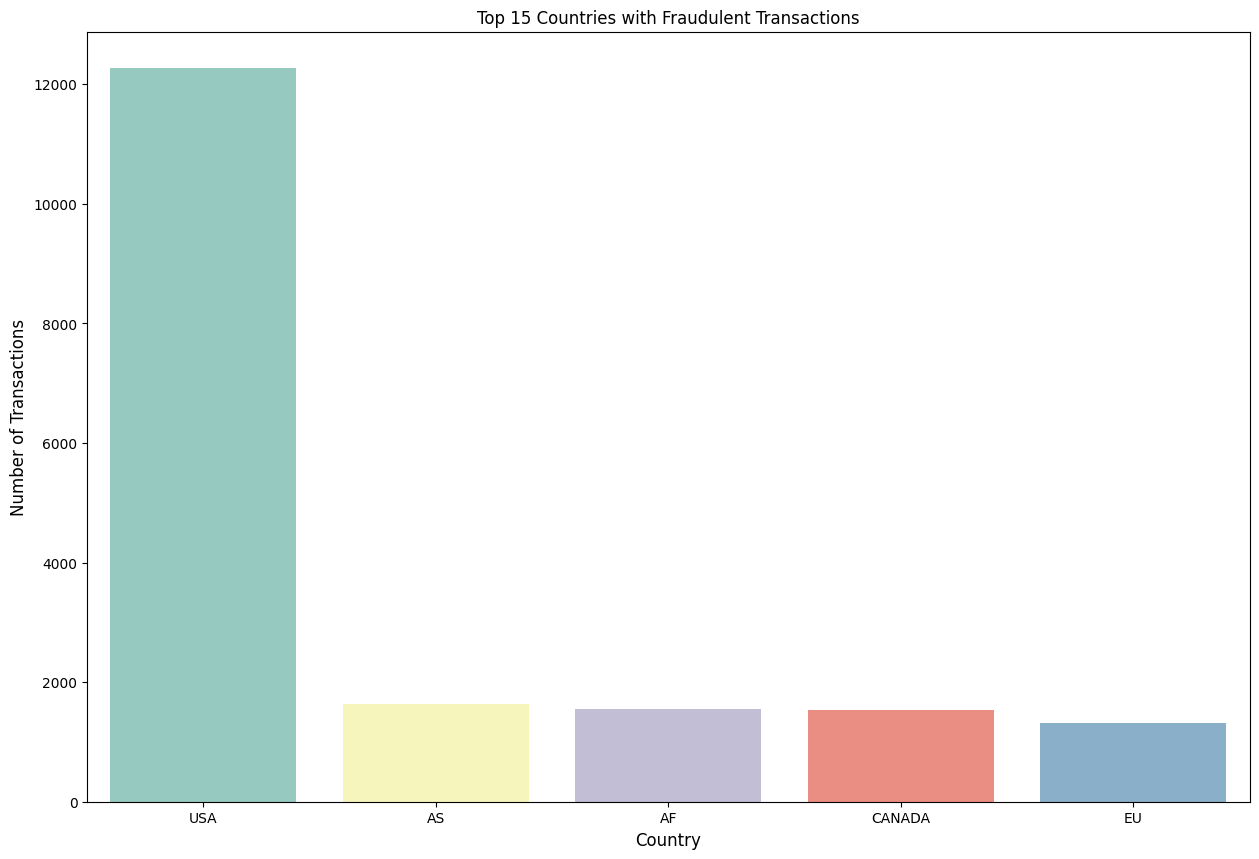

In [1254]:

#in this cell we are going to create a bar chart showing the 15 top countries with the most fraudulant transactions
#First we get all the countries with fraudulant transactions
fraud_countries = df[df['Label'] == 1]['Bene_Country'].value_counts().head(5)
#Then we create a bar chart
plt.figure(figsize=(15,10))
sns.barplot(x=fraud_countries.index, y=fraud_countries.values, palette='Set3')
plt.title('Top 15 Countries with Fraudulent Transactions')
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

In [1255]:
#make a dictionary with each column and its type
dtypes = dict(df.dtypes)
print(dtypes)


{'Time_step': dtype('O'), 'Transaction_Id': dtype('O'), 'Sender_Id': dtype('O'), 'Sender_Account': dtype('O'), 'Sender_Country': dtype('O'), 'Sender_Sector': dtype('float64'), 'Sender_lob': dtype('O'), 'Bene_Id': dtype('O'), 'Bene_Account': dtype('O'), 'Bene_Country': dtype('O'), 'USD_amount': dtype('float64'), 'Label': dtype('float64'), 'Transaction_Type': dtype('O')}


In [1256]:
#count all the rows which have missing value Null OR NaN in all of these columns: Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob
null_count = df['Sender_Id'].isnull().sum() 
print(null_count)

0


In [1257]:
# Crear la nueva columna binaria Sender_ClienteJP, determina si el sender es un cliente del banco.
df['Bene_ClienteJP'] = df['Bene_Id'].apply(lambda x: 1 if x[:4] == 'JPMC' else 0)
print('Número de transacciones recibidas por clientes del banco (1 cliente):\n',df["Bene_ClienteJP"].value_counts())


#Crear la nueva columna binaria que determina si Sender_Country es igual a Bene_Country
df['National_Transaction'] = (df['Sender_Country'] == df['Bene_Country']).astype(int)
print('Número de transacciones nacionales:\n',df["National_Transaction"].value_counts())

#Crea la nueva columna que determina si Sender_Country es igual a USA
df['Sender_USA'] = (df['Sender_Country'] == 'USA').astype(int)
print('Número de transacciones enviadas desde USA:\n',df["Sender_USA"].value_counts())

#Crea la nueva columna que determina si Bene_Country es igual a USA
df['Bene_USA'] = (df['Bene_Country'] == 'USA').astype(int)
print('Número de transacciones recibidas en USA:\n',df["Bene_USA"].value_counts())


Número de transacciones recibidas por clientes del banco (1 cliente):
 0    732669
1    330706
Name: Bene_ClienteJP, dtype: int64
Número de transacciones nacionales:
 0    676431
1    386944
Name: National_Transaction, dtype: int64
Número de transacciones enviadas desde USA:
 1    805481
0    257894
Name: Sender_USA, dtype: int64
Número de transacciones recibidas en USA:
 1    563692
0    499683
Name: Bene_USA, dtype: int64


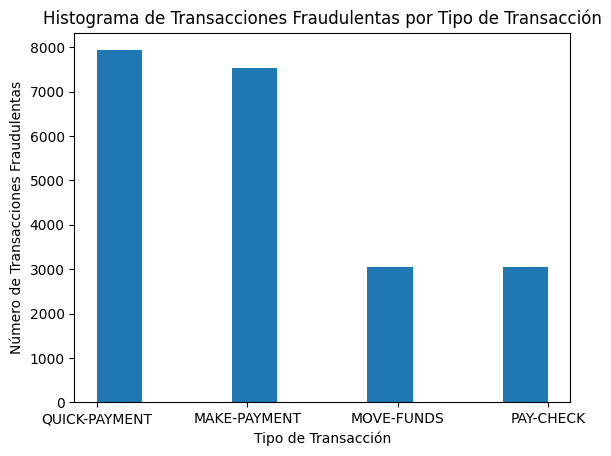

In [1258]:

# Seleccionar solo las transacciones fraudulentas
fraud_df = df[df['Label'] == 1]

# Crear un histograma de los valores de Transaction_Type en las transacciones fraudulentas
# Seleccionar las transacciones fraudulentas
fraudulentas = df[df['Label'] == 1]

# Crear un histograma con las transacciones fraudulentas por tipo de transacción
plt.hist(fraudulentas['Transaction_Type'], bins=10)
plt.xlabel('Tipo de Transacción')
plt.ylabel('Número de Transacciones Fraudulentas')
plt.title('Histograma de Transacciones Fraudulentas por Tipo de Transacción')
plt.show()








In [1259]:
# Crear la nueva columna 'Sender_Company' y asignarle 1 si el valor de 'Sender_Id' contiene "COMPANY"
# y 0 en caso contrario
df["Sender_Company"] = df["Sender_Id"].str.contains("COMPANY").astype(int)
#Cuenta cuantos valores = 1 hay en la columna Sender_Company
df["Sender_Company"].value_counts()
#Si la columna Sender_lob contiene el valor "CCB" asignarle 1 y 0 en caso contrario
df["Sender_lob"] = df["Sender_lob"].str.contains("CCB").astype(int)





In [1260]:
# Crear la nueva columna 'JPMC_Transaction' y asignarle 1 si el valor de 'Sender_Id'y de "Bene_Id" contienen ambas "JPMC"
# y 0 en caso contrario 
df["JPMC_Transaction"] = (df["Sender_Id"].str.contains("JPMC") & df["Bene_Id"].str.contains("JPMC")).astype(int)
#Cuenta cuantos valores = 1 hay en la columna Comp_to_Comp
df["JPMC_Transaction"].value_counts()



0    922885
1    140490
Name: JPMC_Transaction, dtype: int64

C:\Users\docam\AppData\Local\Temp\ipykernel_5048\3175876913.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Sender_Id"] = df["Sender_Id"].str.replace("(COMPANY|CLIENT).*", "\\1")


(array([848146.,      0., 110607.,      0.,      0.,  59204.,      0.,
         25013.,      0.,  20405.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

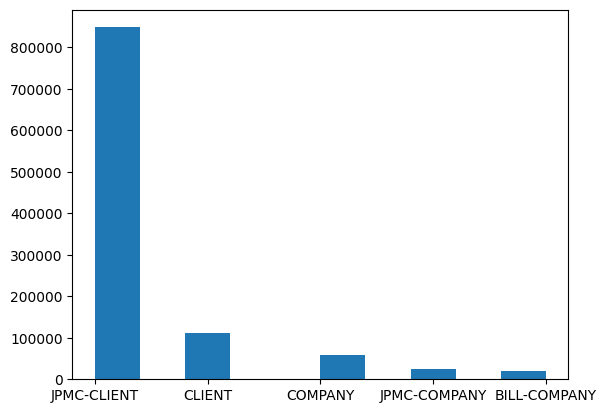

In [1261]:
# Eliminar los caracteres después de "COMPANY" o "CLIENT" en la columna "Sender_Id"
df["Sender_Id"] = df["Sender_Id"].str.replace("(COMPANY|CLIENT).*", "\\1")
#Cuenta cuantos valores hay en la columna Sender_Id
df["Sender_Id"].value_counts()
#Haz un histograma con los valores de la columna Sender_Id
plt.hist(df['Sender_Id'])


C:\Users\docam\AppData\Local\Temp\ipykernel_5048\2986255322.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Bene_Id"] = df["Bene_Id"].str.replace("(COMPANY|CLIENT).*", "\\1")


(array([307042.,      0., 303661.,      0.,      0.,  27045.,      0.,
         63484.,      0., 362143.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

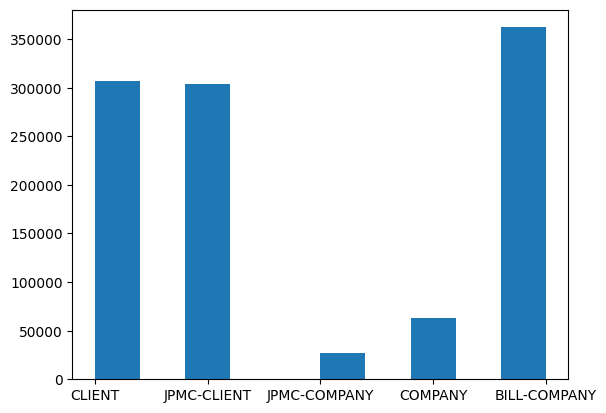

In [1262]:
# Eliminar los caracteres después de "COMPANY" o "CLIENT" en la columna "Sender_Id"
df["Bene_Id"] = df["Bene_Id"].str.replace("(COMPANY|CLIENT).*", "\\1")
#Cuenta cuantos valores hay en la columna Sender_Id
df["Bene_Id"].value_counts()
#Haz un histograma con los valores de la columna Sender_Id
plt.hist(df['Bene_Id'])

In [1263]:
df['Time_step'] = pd.to_datetime(df['Time_step']) # Convertir a datetime 

# Agrupar por Sender_Account
df_grouped = df.groupby('Sender_Account')

# Calcular la diferencia de tiempo en segundos
df['Time_Diff_Last_Trans_Sen'] = (df['Time_step'] - df_grouped['Time_step'].shift()).dt.total_seconds().fillna(0)



In [1264]:
#get statistics of Time_Diff_Last_Trans_Sen
df["Time_Diff_Last_Trans_Sen"].describe()



count    1.063375e+06
mean     1.414700e+05
std      2.075124e+05
min      0.000000e+00
25%      2.400000e+03
50%      4.440000e+04
75%      1.770000e+05
max      4.843800e+06
Name: Time_Diff_Last_Trans_Sen, dtype: float64

In [1265]:
# Sort the data by 'Sender_Account' and 'Time_step'
df.sort_values(by=['Sender_Account', 'Time_step'], inplace=True)

# Define a function to compute the running average excluding the first transaction
def running_average(series):
    return series.shift().expanding().mean().fillna(0)

# Apply the function to each group
df['Average_Diff_Time_Sent'] = df.groupby('Sender_Account')['Time_Diff_Last_Trans_Sen'].apply(running_average)
df['Average_Diff_Time_Sent'] = df['Average_Diff_Time_Sent'].round(2)
df.reset_index(drop=True, inplace=True)

In [1266]:
df['Average_Diff_Time_Sent'].describe()

count    1.063375e+06
mean     1.054226e+05
std      9.200088e+04
min      0.000000e+00
25%      5.900000e+04
50%      8.722500e+04
75%      1.225600e+05
max      2.099400e+06
Name: Average_Diff_Time_Sent, dtype: float64

1 week          478355
24h             318876
1 hour          129978
12h              75063
1 month          59277
more 1 month      1826
Name: Average_Diff_Time_Sent, dtype: int64

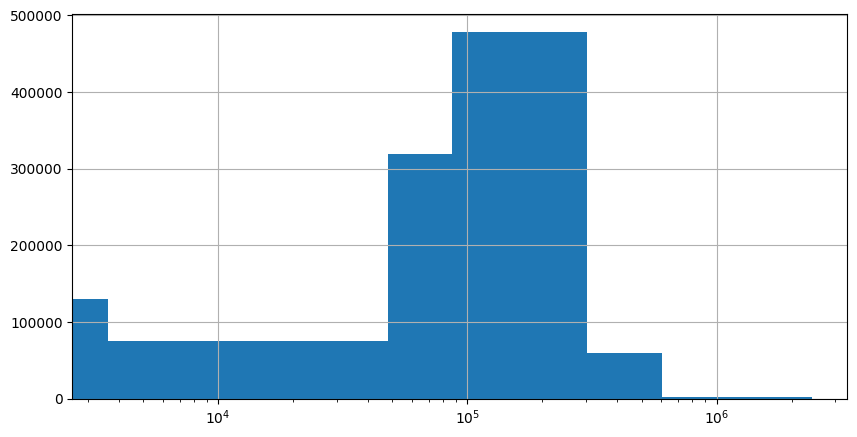

In [1267]:
bins=[-0.1,3600,48000,86400,300800,601600,2419200]
labels = ["1 hour","12h" ,"24h", '1 week', '1 month', 'more 1 month']
plt.xscale("log")
df['Average_Diff_Time_Sent'].hist(bins=bins, figsize=(10,5))
df['Average_Diff_Time_Sent'] = pd.cut(df['Average_Diff_Time_Sent'], bins=bins, labels=labels, right=False)
df['Average_Diff_Time_Sent'].value_counts()

0.1       600.0
0.2       600.0
0.3     43200.0
0.4     43800.0
0.5     44400.0
0.6     87600.0
0.7    135000.0
0.8    259200.0
0.9    394800.0
Name: Time_Diff_Last_Trans_Sen, dtype: float64
12H       238978
1DIA      235587
POCO      196104
SEMANA    152905
3DIA      106581
CERO       75344
MUCHO      57876
Name: Time_Diff_Last_Trans_Sen, dtype: int64
0


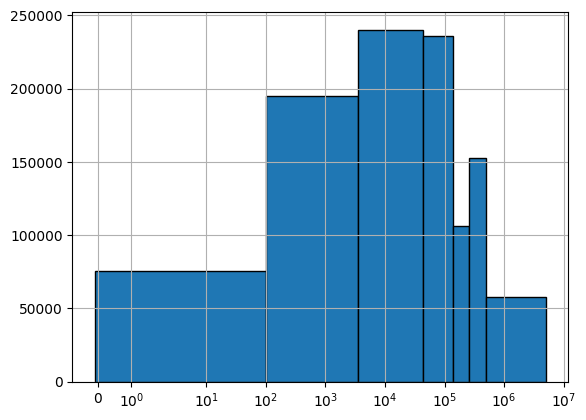

In [1268]:
deciles = df['Time_Diff_Last_Trans_Sen'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
print(deciles)
#create an histogram with Time_Diff_Last_Trans_Sen

plt.xscale('symlog')
bins=[-0.1,100,3600, 44000, 140000, 260000,500000,5000000]
df["Time_Diff_Last_Trans_Sen"].hist(bins=bins, align='mid',edgecolor='black')

df['Time_Diff_Last_Trans_Sen'] = pd.cut(df['Time_Diff_Last_Trans_Sen'], bins=bins, include_lowest=True, labels=["CERO","POCO","12H","1DIA", "3DIA","SEMANA","MUCHO"])
print(df['Time_Diff_Last_Trans_Sen'].value_counts())
print(df["Time_Diff_Last_Trans_Sen"].isna().sum())



In [1269]:
df.sort_values('Time_step', inplace=True)
# Agrupar por Bene_Account
df_group_bene = df.groupby('Bene_Account')

# Calcular la diferencia de tiempo en segundos
df['Time_Diff_Last_Trans_Ben'] = (df['Time_step'] - df_group_bene['Time_step'].shift()).dt.total_seconds().fillna(0)


In [1270]:
#get statistics of Time_Diff_Last_Trans_Sen
df["Time_Diff_Last_Trans_Ben"].describe()


count    1.063375e+06
mean     2.948865e+05
std      4.875287e+05
min      0.000000e+00
25%      0.000000e+00
50%      9.000000e+04
75%      3.918000e+05
max      4.971600e+06
Name: Time_Diff_Last_Trans_Ben, dtype: float64

In [1271]:
# Sort the data by 'Sender_Account' and 'Time_step'
df.sort_values(by=['Bene_Account', 'Time_step'], inplace=True)

# Define a function to compute the running average excluding the first transaction
def running_average(series):
    return series.shift().expanding().mean().fillna(0)

# Apply the function to each group
df['Average_Diff_Time_Rec'] = df.groupby('Bene_Account')['Time_Diff_Last_Trans_Ben'].apply(running_average)
df['Average_Diff_Time_Rec'] = df['Average_Diff_Time_Rec'].round(2)
df.reset_index(drop=True, inplace=True)

In [1272]:
df['Average_Diff_Time_Rec'].describe()

count    1.063375e+06
mean     1.173354e+05
std      1.589375e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.220000e+04
75%      1.841333e+05
max      2.312700e+06
Name: Average_Diff_Time_Rec, dtype: float64

0

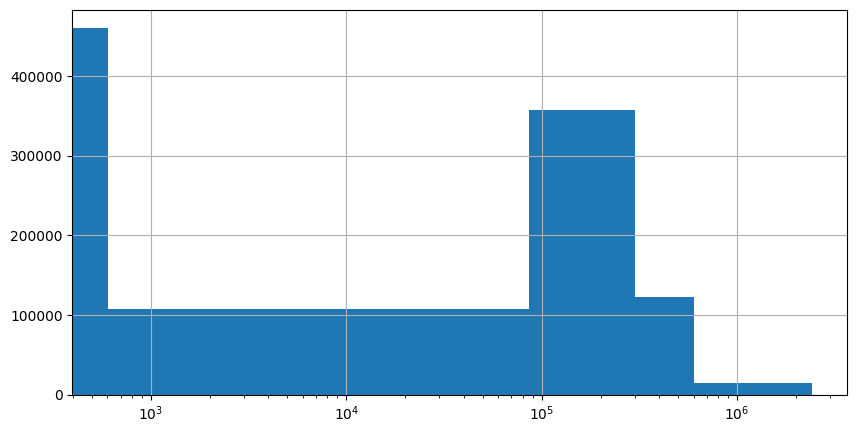

In [1273]:
bins=[-0.1,601,86400,300800,601600,2419200]
labels = ["0" ,"24h", '1 week', '1 month', 'more 1 month']
plt.xscale("log")
df['Average_Diff_Time_Rec'].hist(bins=bins, figsize=(10,5))
df['Average_Diff_Time_Rec'] = pd.cut(df['Average_Diff_Time_Rec'], bins=bins, labels=labels, right=False)
df['Average_Diff_Time_Rec'].value_counts()
df['Average_Diff_Time_Rec'].isna().sum()

0.1         0.0
0.2         0.0
0.3       600.0
0.4     43800.0
0.5     90000.0
0.6    177000.0
0.7    306600.0
0.8    478200.0
0.9    787200.0
Name: Time_Diff_Last_Trans_Ben, dtype: float64
CERO      294155
MUCHO     190113
SEMANA    181688
1DIA      162730
3DIA       97905
POCO       72569
12H        64215
Name: Time_Diff_Last_Trans_Ben, dtype: int64
0


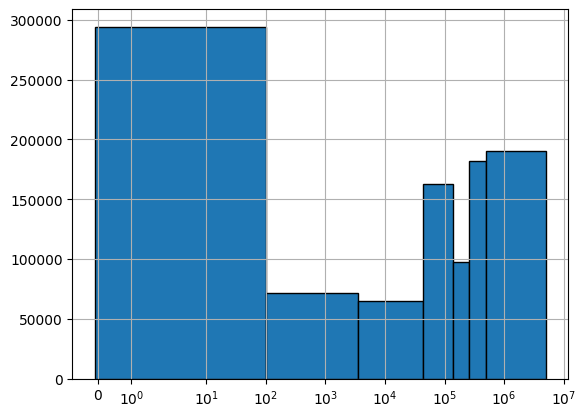

In [1274]:
deciles = df['Time_Diff_Last_Trans_Ben'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
print(deciles)
#create an histogram with Time_Diff_Last_Trans_Sen

plt.xscale('symlog')
bins=[-0.1,100,3600, 44000, 140000, 260000,500000,5000000]
df["Time_Diff_Last_Trans_Ben"].hist(bins=bins, align='mid',edgecolor='black')

df['Time_Diff_Last_Trans_Ben'] = pd.cut(df['Time_Diff_Last_Trans_Ben'], bins=bins, include_lowest=True, labels=["CERO","POCO","12H","1DIA", "3DIA","SEMANA","MUCHO"])
print(df['Time_Diff_Last_Trans_Ben'].value_counts())
#check NA values in Time_Diff_Last_Trans_Ben
print(df["Time_Diff_Last_Trans_Ben"].isna().sum())


In [1275]:
df_grouped = df.groupby('Sender_Account')
df['average_USD_sent'] = df_grouped['USD_amount'].expanding().mean().shift(fill_value=0).reset_index(level=0, drop=True)


In [1276]:
df["average_USD_sent"].describe()

count    1.063375e+06
mean     5.713511e+02
std      4.217237e+02
min      0.000000e+00
25%      4.014432e+02
50%      4.626233e+02
75%      5.360303e+02
max      1.970091e+04
Name: average_USD_sent, dtype: float64

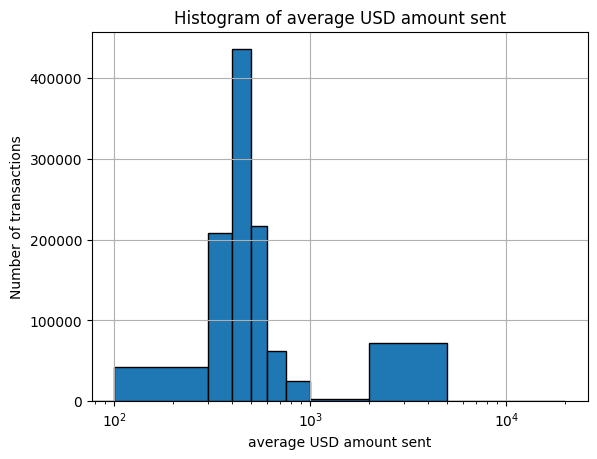

400     435710
500     217142
300     208177
2000     72297
600      61732
100      41641
750      24401
1000      2042
5000       140
10          93
Name: average_USD_sent, dtype: int64


In [1277]:
bins=[-0.1,100,300,400,500,600,750,1000,2000,5000,20000]
df["average_USD_sent"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('average USD amount sent')
plt.xscale('log')
plt.ylabel('Number of transactions')
plt.title('Histogram of average USD amount sent')
plt.show()
df["average_USD_sent"] = pd.cut(df["average_USD_sent"], bins=bins, labels=["10", "100","300","400","500","600","750","1000","2000","5000",])
print(df["average_USD_sent"].value_counts())

In [1278]:
df_grouped = df.groupby('Bene_Account')
df['average_USD_rec'] = df_grouped['USD_amount'].expanding().mean().shift(fill_value=0).reset_index(level=0, drop=True)

In [1279]:
df["average_USD_rec"].describe()

count    1.063375e+06
mean     4.740364e+02
std      3.704867e+02
min      0.000000e+00
25%      1.854700e+02
50%      4.476000e+02
75%      6.042000e+02
max      1.970091e+04
Name: average_USD_rec, dtype: float64

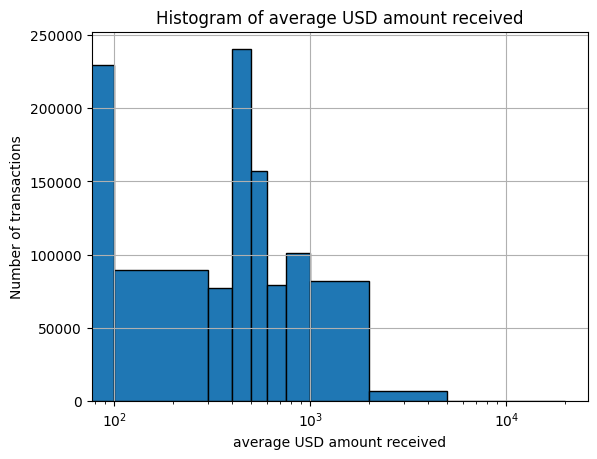

400     240267
10      229254
500     157410
750     101188
100      89443
1000     81929
600      79025
300      77490
2000      7224
5000       145
Name: average_USD_rec, dtype: int64


In [1280]:
bins=[-0.1,100,300,400,500,600,750,1000,2000,5000,20000]
df["average_USD_rec"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('average USD amount received')
plt.xscale('log')
plt.ylabel('Number of transactions')
plt.title('Histogram of average USD amount received')
plt.show()
df["average_USD_rec"] = pd.cut(df["average_USD_rec"], bins=bins, labels=["10", "100","300","400","500","600","750","1000","2000","5000",])
print(df["average_USD_rec"].value_counts())

In [1281]:
df['Max_USD_Sent'] = df.groupby('Sender_Account')['USD_amount'].transform('max')
df['Max_USD_Rec'] = df.groupby('Bene_Account')['USD_amount'].transform('max')
df['Min_USD_Sent'] = df.groupby('Sender_Account')['USD_amount'].transform('min')
df['Min_USD_Rec'] = df.groupby('Bene_Account')['USD_amount'].transform('min')

In [1282]:
df['Max_USD_Sent'].describe()

count    1.063375e+06
mean     1.101698e+03
std      9.811959e+02
min      9.157000e+01
25%      9.385800e+02
50%      9.727200e+02
75%      9.906800e+02
max      1.992799e+04
Name: Max_USD_Sent, dtype: float64

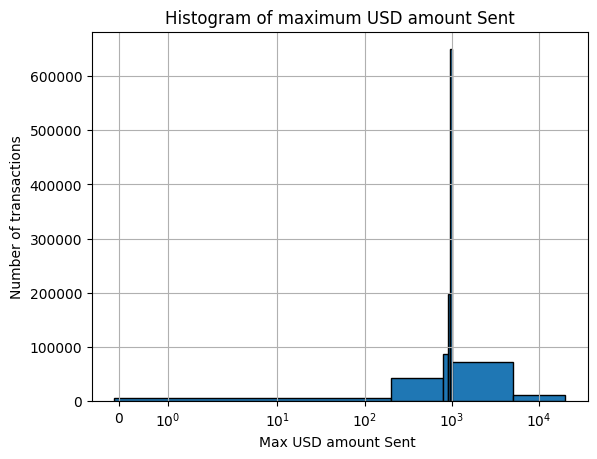

MUCHO         649521
MEDIO         197262
MEDIO POCO     86331
MUCHISIMO      71797
POCO           41989
MAXIMO         10537
MUY POCO        5938
Name: Max_USD_Sent, dtype: int64


In [1283]:
bins=[-0.1,200,800,900,950,1000,5000,20000]
df["Max_USD_Sent"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('Max USD amount Sent ')
plt.xscale('symlog')
plt.ylabel('Number of transactions')
plt.title('Histogram of maximum USD amount Sent')
plt.show()

df["Max_USD_Sent"] = pd.cut(df["Max_USD_Sent"], bins=bins, labels=["MUY POCO", "POCO","MEDIO POCO","MEDIO","MUCHO","MUCHISIMO","MAXIMO"])
print(df["Max_USD_Sent"].value_counts())



In [1284]:
df['Max_USD_Rec'].describe()

count    1.063375e+06
mean     1.005112e+03
std      1.021502e+03
min      1.000000e-02
25%      4.093050e+02
50%      9.363800e+02
75%      9.967000e+02
max      1.992799e+04
Name: Max_USD_Rec, dtype: float64

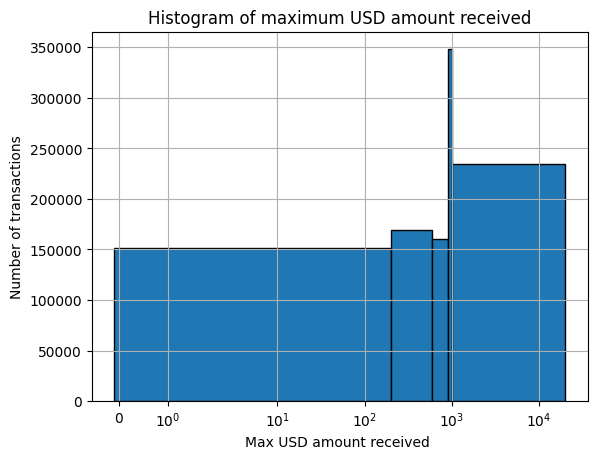

MUCHO       347981
MAXIMO      234521
POCO        169012
MEDIO       160054
MUY POCO    151807
Name: Max_USD_Rec, dtype: int64


In [1285]:
bins=[-0.1,200,600,900,1000,20000]
df["Max_USD_Rec"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('Max USD amount received ')
plt.xscale('symlog')
plt.ylabel('Number of transactions')
plt.title('Histogram of maximum USD amount received')
plt.show()

df["Max_USD_Rec"] = pd.cut(df["Max_USD_Rec"], bins=bins, labels=["MUY POCO", "POCO","MEDIO","MUCHO","MAXIMO"])
print(df["Max_USD_Rec"].value_counts())

In [1286]:
df['Min_USD_Sent'].describe()

count    1.063375e+06
mean     1.758376e+02
std      5.083260e+02
min      1.000000e-02
25%      3.690000e+00
50%      1.034000e+01
75%      4.921000e+01
max      1.907559e+04
Name: Min_USD_Sent, dtype: float64

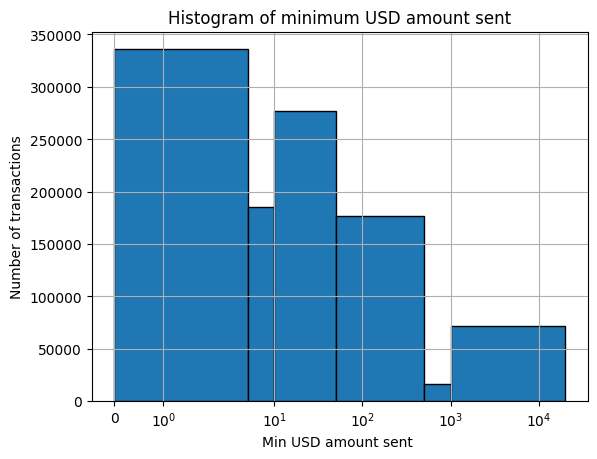

MUY POCO     336572
MEDIO        276200
POCO         185425
MUCHO        176798
MAXIMO        71843
MUCHISIMO     16537
Name: Min_USD_Sent, dtype: int64
0


In [1287]:
bins=[0,5,10,50,500,2500,20000]
df["Min_USD_Sent"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('Min USD amount sent ')
plt.xscale('symlog')
plt.ylabel('Number of transactions')
plt.title('Histogram of minimum USD amount sent')
plt.show()

df["Min_USD_Sent"] = pd.cut(df["Min_USD_Sent"], bins=bins, labels=["MUY POCO", "POCO","MEDIO","MUCHO","MUCHISIMO","MAXIMO"])
print(df["Min_USD_Sent"].value_counts())
print(df["Min_USD_Sent"].isna().sum())

In [1288]:
df['Min_USD_Rec'].describe()

count    1.063375e+06
mean     1.326249e+02
std      1.331270e+02
min      1.000000e-02
25%      7.352000e+01
50%      1.001700e+02
75%      1.009500e+02
max      9.000940e+03
Name: Min_USD_Rec, dtype: float64

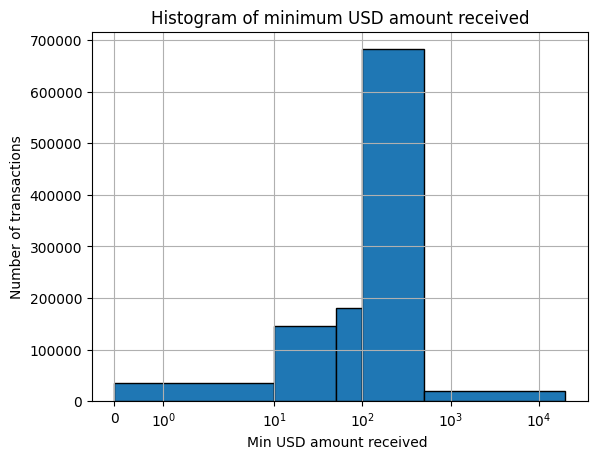

MUCHO       670393
MEDIO       193000
POCO        145011
MUY POCO     35927
MAXIMO       19044
Name: Min_USD_Rec, dtype: int64
0


In [1289]:
bins=[0,10,50,100,500,20000]
df["Min_USD_Rec"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('Min USD amount received ')
plt.xscale('symlog')
plt.ylabel('Number of transactions')
plt.title('Histogram of minimum USD amount received')
plt.show()

df["Min_USD_Rec"] = pd.cut(df["Min_USD_Rec"], bins=bins, labels=["MUY POCO", "POCO","MEDIO","MUCHO","MAXIMO"])
print(df["Min_USD_Rec"].value_counts())
print(df["Min_USD_Rec"].isna().sum())

In [1290]:

print(df[df['Sender_Account'] == "ACCOUNT-8957" ].head(10))

                  Time_step      Transaction_Id    Sender_Id Sender_Account  \
1006699 2022-03-15 11:04:00       PAY-BILL-8972  JPMC-CLIENT   ACCOUNT-8957   
1006701 2022-03-27 15:24:00  QUICK-PAYMENT-9027  JPMC-CLIENT   ACCOUNT-8957   
1006831 2022-03-27 16:04:00  QUICK-PAYMENT-9031  JPMC-CLIENT   ACCOUNT-8957   
1007068 2022-03-20 00:04:00        PAYMENT-8986  JPMC-CLIENT   ACCOUNT-8957   
1007070 2022-03-30 04:24:00        PAYMENT-9037  JPMC-CLIENT   ACCOUNT-8957   
1007074 2022-04-24 09:54:00        PAYMENT-9141  JPMC-CLIENT   ACCOUNT-8957   
1007075 2022-04-28 22:44:00        PAYMENT-9166  JPMC-CLIENT   ACCOUNT-8957   
1007214 2022-03-23 13:24:00  QUICK-PAYMENT-9006  JPMC-CLIENT   ACCOUNT-8957   
1007240 2022-03-15 23:04:00       PAY-BILL-8971  JPMC-CLIENT   ACCOUNT-8957   
1007241 2022-03-17 23:44:00       PAY-BILL-8980  JPMC-CLIENT   ACCOUNT-8957   

        Sender_Country  Sender_Sector  Sender_lob       Bene_Id  Bene_Account  \
1006699            USA        24042.0           1

In [1291]:
print(df[df['Sender_Account'] == "ACCOUNT-8966" ].head(10))

                  Time_step      Transaction_Id Sender_Id Sender_Account  \
1006897 2022-03-17 23:04:00     MOVE-FUNDS-8977    CLIENT   ACCOUNT-8966   
1006900 2022-03-27 15:34:00   MAKE-PAYMENT-9028    CLIENT   ACCOUNT-8966   
1006901 2022-03-29 04:14:00      PAY-CHECK-9035    CLIENT   ACCOUNT-8966   
1006903 2022-04-12 19:04:00  QUICK-PAYMENT-9100    CLIENT   ACCOUNT-8966   
1006904 2022-04-20 21:04:00  QUICK-PAYMENT-9134    CLIENT   ACCOUNT-8966   
1006907 2022-05-08 12:04:00      PAY-CHECK-9206    CLIENT   ACCOUNT-8966   
1006908 2022-05-10 00:44:00   MAKE-PAYMENT-9212    CLIENT   ACCOUNT-8966   
1006931 2022-03-22 12:44:00      PAY-CHECK-9001    CLIENT   ACCOUNT-8966   
1006932 2022-03-24 13:34:00   MAKE-PAYMENT-9010    CLIENT   ACCOUNT-8966   
1006933 2022-03-25 13:54:00  QUICK-PAYMENT-9023    CLIENT   ACCOUNT-8966   

        Sender_Country  Sender_Sector  Sender_lob      Bene_Id  Bene_Account  \
1006897             AF        18401.0           1  JPMC-CLIENT  ACCOUNT-8957   
100

In [1292]:
print(df[df['Bene_Account'] == "ACCOUNT-8957" ].head(10))

                  Time_step      Transaction_Id     Sender_Id Sender_Account  \
1006897 2022-03-17 23:04:00     MOVE-FUNDS-8977        CLIENT   ACCOUNT-8966   
1006898 2022-03-18 11:44:00      PAY-CHECK-8981  JPMC-COMPANY   ACCOUNT-8955   
1006899 2022-03-19 12:04:00     MOVE-FUNDS-8985  JPMC-COMPANY   ACCOUNT-8959   
1006900 2022-03-27 15:34:00   MAKE-PAYMENT-9028        CLIENT   ACCOUNT-8966   
1006901 2022-03-29 04:14:00      PAY-CHECK-9035        CLIENT   ACCOUNT-8966   
1006902 2022-03-30 16:34:00     MOVE-FUNDS-9036  JPMC-COMPANY   ACCOUNT-8959   
1006903 2022-04-12 19:04:00  QUICK-PAYMENT-9100        CLIENT   ACCOUNT-8966   
1006904 2022-04-20 21:04:00  QUICK-PAYMENT-9134        CLIENT   ACCOUNT-8966   
1006905 2022-04-23 21:54:00     MOVE-FUNDS-9140  JPMC-COMPANY   ACCOUNT-8959   
1006906 2022-04-28 22:34:00     MOVE-FUNDS-9165  JPMC-COMPANY   ACCOUNT-8959   

        Sender_Country  Sender_Sector  Sender_lob      Bene_Id  Bene_Account  \
1006897             AF        18401.0  

In [1293]:
#drop from df columns 'Time_step', 'Transaction_Id',"Sender_Sector, "Bene_Account".
df = df.drop(['Time_step', 'Transaction_Id',"Sender_Sector","Sender_Account", "Bene_Account"], axis=1)


count    1.063375e+06
mean     5.104796e+02
std      5.462105e+02
min      1.000000e-02
25%      1.006900e+02
50%      4.004400e+02
75%      7.229600e+02
max      1.992799e+04
Name: USD_amount, dtype: float64
[0, 1, 10, 100, 250, 500, 1000, 20000]


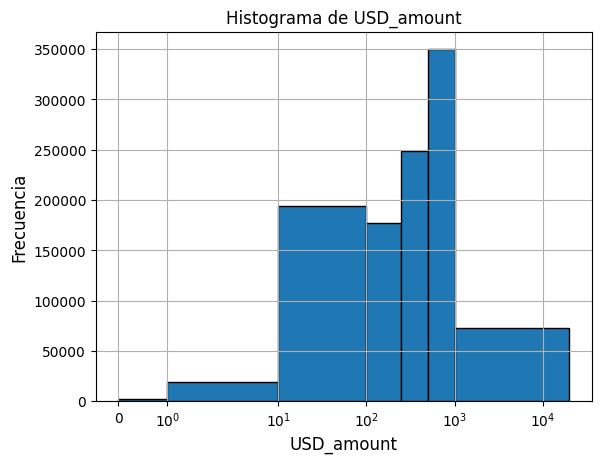

ALTA         350023
CASI ALTA    248592
NORMAL       194668
MEDIO        176409
MUY ALTA      72302
POCO          19273
MUY POCO       2108
Name: USD_amount, dtype: int64


In [1294]:
#show statistics of USD_amount in df
print(df['USD_amount'].describe())
plt.xscale('symlog')
bins=[0,1,10, 100,250, 500, 1000, 20000]
print(bins)
df["USD_amount"].hist(bins=bins, align='mid',edgecolor='black')
plt.xlabel('USD_amount', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Histograma de USD_amount', fontsize=12)
plt.show()
##discretiza los valores de la columna en, los iguales a 0,1,10, 100,500, 1000, 10000
df['USD_amount'] = pd.cut(df['USD_amount'], bins=bins, labels=["MUY POCO", "POCO", "NORMAL", "MEDIO","CASI ALTA", "ALTA", "MUY ALTA"])
print(df['USD_amount'].value_counts())



1063375
Sender_Id                   0
Sender_Country              0
Sender_lob                  0
Bene_Id                     0
Bene_Country                0
USD_amount                  0
Label                       0
Transaction_Type            0
Bene_ClienteJP              0
National_Transaction        0
Sender_USA                  0
Bene_USA                    0
Sender_Company              0
JPMC_Transaction            0
Time_Diff_Last_Trans_Sen    0
Average_Diff_Time_Sent      0
Time_Diff_Last_Trans_Ben    0
Average_Diff_Time_Rec       0
average_USD_sent            0
average_USD_rec             0
Max_USD_Sent                0
Max_USD_Rec                 0
Min_USD_Sent                0
Min_USD_Rec                 0
dtype: int64
Index(['Sender_Id', 'Sender_Country', 'Sender_lob', 'Bene_Id', 'Bene_Country',
       'USD_amount', 'Label', 'Transaction_Type', 'Bene_ClienteJP',
       'National_Transaction', 'Sender_USA', 'Bene_USA', 'Sender_Company',
       'JPMC_Transaction', 'Time_Diff

<AxesSubplot:ylabel='USD_amount'>

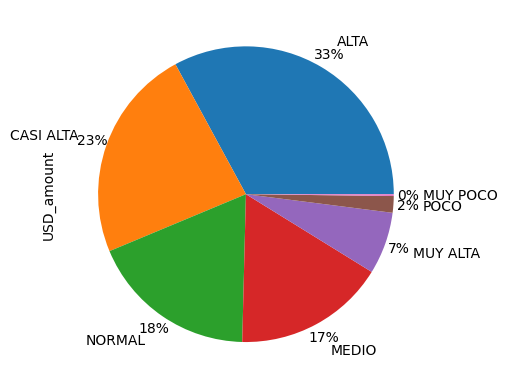

In [1295]:
print(df['USD_amount'].value_counts().sum())
print(df.isna().sum())
print(df.columns)
#crea un pie chart con los valores de la columna USD_amount
df['USD_amount'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

In [1296]:
"""
# Seleccionar columnas para aplicar one-hot encoding
columns_to_encode = ['Sender_Id', 'Sender_lob', 'Bene_Id',"USD_amount", 'Bene_Country', 'Transaction_Type']

# Crear una lista con las columnas que no se deben binarizar
non_binary_columns = ['Sender_USA', 'Bene_USA','Label', 'Time_Diff_Last_Trans', 'Time_Diff_Last_Trans_Ben', 'Bene_ClienteJP', 'National_Transaction', 'Sender_Company', 'JPMC_Transaction']


# Filtrar el dataframe con las columnas seleccionadas
df_encoded = df[columns_to_encode]

# Inicializar el codificador one-hot
encoder = OneHotEncoder(handle_unknown='ignore')

# Ajustar el codificador a las columnas seleccionadas
encoder.fit(df_encoded)

# Codificar las columnas seleccionadas
encoded_columns = encoder.transform(df_encoded).toarray()

# Crear un nuevo dataframe con las columnas codificadas
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(df_encoded.columns))
print(encoded_df.isna().sum())
print(df.isna().sum())
# Combinar el dataframe original con el dataframe codificado
df = pd.concat([df.iloc[:, :-2], encoded_df, df.iloc[:, -2:]], axis=1)

"""
print(df.columns)

# Seleccionar columnas para aplicar one-hot encoding
columns_to_encode = df.columns[0:]

# Filtrar el dataframe con las columnas seleccionadas
df_encoded = df[columns_to_encode]

# Inicializar el codificador one-hot
encoder = OneHotEncoder(handle_unknown='ignore')

# Ajustar el codificador a las columnas seleccionadas
encoder.fit(df_encoded)
print("ENCODER",encoder.get_feature_names_out(columns_to_encode))
# Codificar las columnas seleccionadas
encoded_columns = encoder.transform(df_encoded).toarray()

# create a new dataframe with the encoded columns
df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
print("ENCODED",df.info())
print(df.isna().sum())
# Crear un nuevo dataframe con las columnas codificadas
#encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(df_encoded.columns))



Index(['Sender_Id', 'Sender_Country', 'Sender_lob', 'Bene_Id', 'Bene_Country',
       'USD_amount', 'Label', 'Transaction_Type', 'Bene_ClienteJP',
       'National_Transaction', 'Sender_USA', 'Bene_USA', 'Sender_Company',
       'JPMC_Transaction', 'Time_Diff_Last_Trans_Sen',
       'Average_Diff_Time_Sent', 'Time_Diff_Last_Trans_Ben',
       'Average_Diff_Time_Rec', 'average_USD_sent', 'average_USD_rec',
       'Max_USD_Sent', 'Max_USD_Rec', 'Min_USD_Sent', 'Min_USD_Rec'],
      dtype='object')
ENCODER ['Sender_Id_BILL-COMPANY' 'Sender_Id_CLIENT' 'Sender_Id_COMPANY'
 'Sender_Id_JPMC-CLIENT' 'Sender_Id_JPMC-COMPANY' 'Sender_Country_AF'
 'Sender_Country_AN' 'Sender_Country_AS' 'Sender_Country_CANADA'
 'Sender_Country_Desconocido' 'Sender_Country_EU' 'Sender_Country_GERMANY'
 'Sender_Country_NA' 'Sender_Country_OC' 'Sender_Country_SA'
 'Sender_Country_USA' 'Sender_lob_1' 'Bene_Id_BILL-COMPANY'
 'Bene_Id_CLIENT' 'Bene_Id_COMPANY' 'Bene_Id_JPMC-CLIENT'
 'Bene_Id_JPMC-COMPANY' 'Bene_Country

In [1297]:
# Lista de columnas que deseas buscar
columnas_a_buscar = ['Label_0.0', 'Bene_ClienteJP_0', 'National_Transaction_0', 'Sender_USA_0',
                     'Bene_USA_0', 'Sender_Company_0', 'JPMC_Transaction_0']

# Obtener el índice de las columnas a eliminar
lista_col_drop = []
for i, col in enumerate(df.columns):
    if col in columnas_a_buscar:
        lista_col_drop.append(i)

# Ahora 'lista_col_drop' es una lista que contiene las posiciones (índices) de las columnas
# especificadas en 'columnas_a_buscar'.

# Puedes utilizar la lista 'lista_col_drop' para eliminar las columnas del DataFrame si lo deseas.

df= df.drop(df.columns[lista_col_drop], axis=1)

In [1298]:

print(df.info())
print(df.isna().sum())
#rellenar NaN con 0
df = df.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063375 entries, 0 to 1063374
Columns: 119 entries, Sender_Id_BILL-COMPANY to Min_USD_Rec_POCO
dtypes: float64(119)
memory usage: 965.4 MB
None
Sender_Id_BILL-COMPANY    0
Sender_Id_CLIENT          0
Sender_Id_COMPANY         0
Sender_Id_JPMC-CLIENT     0
Sender_Id_JPMC-COMPANY    0
                         ..
Min_USD_Rec_MAXIMO        0
Min_USD_Rec_MEDIO         0
Min_USD_Rec_MUCHO         0
Min_USD_Rec_MUY POCO      0
Min_USD_Rec_POCO          0
Length: 119, dtype: int64


In [1299]:
# Obtener el índice de la columna "Label_1.0"
label_index = df.columns.get_loc("Label_1.0")

# Obtener los datos de la columna a predecir y el resto de las columnas
y = df.iloc[:, label_index]
X = df.iloc[:, df.columns != "Label_1.0"]
# Separar en train y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [1300]:
df.head()

,Sender_Id_BILL-COMPANY,Sender_Id_CLIENT,Sender_Id_COMPANY,Sender_Id_JPMC-CLIENT,Sender_Id_JPMC-COMPANY,Sender_Country_AF,Sender_Country_AN,Sender_Country_AS,Sender_Country_CANADA,Sender_Country_Desconocido,...,Min_USD_Sent_MEDIO,Min_USD_Sent_MUCHISIMO,Min_USD_Sent_MUCHO,Min_USD_Sent_MUY POCO,Min_USD_Sent_POCO,Min_USD_Rec_MAXIMO,Min_USD_Rec_MEDIO,Min_USD_Rec_MUCHO,Min_USD_Rec_MUY POCO,Min_USD_Rec_POCO
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1301]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {X_train.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(X_train, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((850700, 118), (850700,))
Shape of the training after SMOTE: ((1666842, 118), (1666842,))


In [1302]:
y_tr_resample.head()
y_tr_resample.value_counts()

0.0    833421
1.0    833421
Name: Label_1.0, dtype: int64

In [1303]:
# Fit the logistic regression model to the resampled training data
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)
preds = LR.predict(X_test)

print(y_test.shape)
y_test.value_counts()

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

score = roc_auc_score(y_test, preds)
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

c:\Users\docam\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(212675,)
              precision    recall  f1-score   support

         0.0       0.99      0.59      0.74    208392
         1.0       0.04      0.73      0.07      4283

    accuracy                           0.60    212675
   macro avg       0.51      0.66      0.41    212675
weighted avg       0.97      0.60      0.73    212675

[[123696  84696]
 [  1145   3138]]


In [1304]:
"""# Initialize the KNN classifier with 4 nearest neighbors
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_tr_resample, y_tr_resample)  # Fit the classifier to the resampled training data

preds = knn.predict(X_test)  # Predict the target variable for the test data

# Calculate the accuracy
score = roc_auc_score(y_test, preds)

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

fpr, tpr, threshold = roc_curve(y_test, preds)
"""

'# Initialize the KNN classifier with 4 nearest neighbors\nknn = KNeighborsClassifier(n_neighbors=4)\nknn.fit(x_tr_resample, y_tr_resample)  # Fit the classifier to the resampled training data\n\npreds = knn.predict(X_test)  # Predict the target variable for the test data\n\n# Calculate the accuracy\nscore = roc_auc_score(y_test, preds)\n\nprint(classification_report(y_test, preds))\nprint(confusion_matrix(y_test, preds))\n\nfpr, tpr, threshold = roc_curve(y_test, preds)\n'

In [1305]:
"""
suvm = svm.SVC(decision_function_shape='ovo')
suvm.fit(x_tr_resample, y_tr_resample)
preds=suvm.predict(X_test)
# Calculate the accuracy
score = roc_auc_score(y_test, preds)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
"""

"\nsuvm = svm.SVC(decision_function_shape='ovo')\nsuvm.fit(x_tr_resample, y_tr_resample)\npreds=suvm.predict(X_test)\n# Calculate the accuracy\nscore = roc_auc_score(y_test, preds)\nprint(classification_report(y_test, preds))\nprint(confusion_matrix(y_test, preds))\n"

In [1306]:
##Naive Bayes algorithm

nbayes = GaussianNB()
nbayes.fit(x_tr_resample, y_tr_resample)
preds=nbayes.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


              precision    recall  f1-score   support

         0.0       1.00      0.30      0.46    208392
         1.0       0.03      0.97      0.05      4283

    accuracy                           0.31    212675
   macro avg       0.51      0.63      0.25    212675
weighted avg       0.98      0.31      0.45    212675

[[ 61585 146807]
 [   132   4151]]


c:\Users\docam\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.28588
[1]	validation_0-error:0.25065
[2]	validation_0-error:0.21634
[3]	validation_0-error:0.17876
[4]	validation_0-error:0.15067
[5]	validation_0-error:0.14359
[6]	validation_0-error:0.12184
[7]	validation_0-error:0.09974
[8]	validation_0-error:0.08989
[9]	validation_0-error:0.07753
[10]	validation_0-error:0.06383
[11]	validation_0-error:0.05964
[12]	validation_0-error:0.05394
[13]	validation_0-error:0.05060
[14]	validation_0-error:0.04516
[15]	validation_0-error:0.03752
[16]	validation_0-error:0.03535
[17]	validation_0-error:0.03224
[18]	validation_0-error:0.02984
[19]	validation_0-error:0.02805
[20]	validation_0-error:0.02757
[21]	validation_0-error:0.02641
[22]	validation_0-error:0.02544
[23]	validation_0-error:0.02475
[24]	validation_0-error:0.02358
[25]	validation_0-error:0.02302
[26]	validation_0-error:0.02215
[27]	validation_0-error:0.02163
[28]	validation_0-error:0.02092
[29]	validation_0-error:0.02081
[30]	validation_0-error:0.02039
[31]	validation_0-

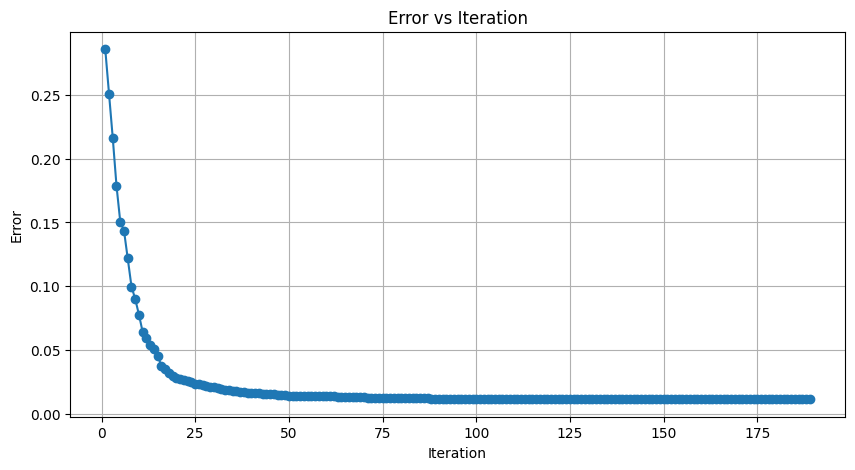

In [1307]:


# Dividir los datos de entrenamiento en un conjunto de entrenamiento y validación
x_tr, x_val, y_tr, y_val = train_test_split(x_tr_resample, y_tr_resample, test_size=0.2)

eval_set = [(x_val, y_val)]

# Ajustar el modelo con early stopping
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error', n_estimators=500)
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

# Obtener los errores de validación
validation_errors = xgb_clf.evals_result()['validation_0']['error']

# Generar la gráfica del error
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(validation_errors) + 1), validation_errors, marker='o')
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid()
plt.savefig('error_vs_iteration.png')
plt.show()


In [1308]:
preds = xgb_clf.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    208392
         1.0       0.90      0.14      0.24      4283

    accuracy                           0.98    212675
   macro avg       0.94      0.57      0.62    212675
weighted avg       0.98      0.98      0.98    212675

[[208328     64]
 [  3692    591]]


In [1309]:
"""
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Definir los parámetros para la búsqueda
parameters = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.07,0.15,0.25],
    'subsample': [0.2,0.5,0.8],
    'n_estimators': [100,500,1000],
}

results = []

# Iterar sobre cada parámetro y valor
for param in parameters:
    precision_values = []
    recall_values = []
    for value in parameters[param]:

        # Configurar el clasificador XGB con el parámetro y valor actual
        xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **{param: value})

        # Entrenar el clasificador XGB
        xgb_clf.fit(x_tr_resample, y_tr_resample)

        # Predecir con el modelo
        preds = xgb_clf.predict(X_test)

        # Obtener el informe de clasificación
        report = classification_report(y_test, preds, output_dict=True)

        # Guardar los resultados
        result = {
            'parameter': param,
            'value': value,
            'accuracy': report['accuracy'],
            'macro avg precision': report['macro avg']['precision'],
            'macro avg recall': report['macro avg']['recall'],
            'macro avg f1-score': report['macro avg']['f1-score'],
        }
        results.append(result)

        # Añadir las métricas a sus respectivas listas para la gráfica
        precision_values.append(report['macro avg']['precision'])
        recall_values.append(report['macro avg']['recall'])

        # Imprimir los resultados
        print(f"Parameter: {param}, Value: {value}, Accuracy: {report['accuracy']}, Macro Avg Precision: {report['macro avg']['precision']}, Macro Avg Recall: {report['macro avg']['recall']}, Macro Avg F1-score: {report['macro avg']['f1-score']}")

    # Generar la gráfica de precision
    plt.figure(figsize=(10, 5))
    plt.plot(parameters[param], precision_values, marker='o')
    plt.title(f'Precision vs {param}')
    plt.xlabel(param)
    plt.ylabel('Precision')
    plt.grid()
    plt.savefig(f'precision_vs_{param}.png')
    plt.show()

    # Generar la gráfica de recall
    plt.figure(figsize=(10, 5))
    plt.plot(parameters[param], recall_values, marker='o')
    plt.title(f'Recall vs {param}')
    plt.xlabel(param)
    plt.ylabel('Recall')
    plt.grid()
    plt.savefig(f'recall_vs_{param}.png')
    plt.show()

# Convertir los resultados en un DataFrame
df_results = pd.DataFrame(results)

# Guardar los resultados en un archivo CSV
df_results.to_csv('xgb_results.csv', index=False)
"""

'\nimport matplotlib.pyplot as plt\nimport pandas as pd\nfrom sklearn.metrics import classification_report\n\n# Definir los parámetros para la búsqueda\nparameters = {\n    \'max_depth\': [3, 6, 10],\n    \'learning_rate\': [0.07,0.15,0.25],\n    \'subsample\': [0.2,0.5,0.8],\n    \'n_estimators\': [100,500,1000],\n}\n\nresults = []\n\n# Iterar sobre cada parámetro y valor\nfor param in parameters:\n    precision_values = []\n    recall_values = []\n    for value in parameters[param]:\n\n        # Configurar el clasificador XGB con el parámetro y valor actual\n        xgb_clf = xgb.XGBClassifier(objective=\'binary:logistic\', eval_metric=\'auc\', **{param: value})\n\n        # Entrenar el clasificador XGB\n        xgb_clf.fit(x_tr_resample, y_tr_resample)\n\n        # Predecir con el modelo\n        preds = xgb_clf.predict(X_test)\n\n        # Obtener el informe de clasificación\n        report = classification_report(y_test, preds, output_dict=True)\n\n        # Guardar los resultados

              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55    208392
         1.0       0.03      0.95      0.06      4283

    accuracy                           0.39    212675
   macro avg       0.51      0.67      0.30    212675
weighted avg       0.98      0.39      0.54    212675

[[ 78652 129740]
 [   197   4086]]


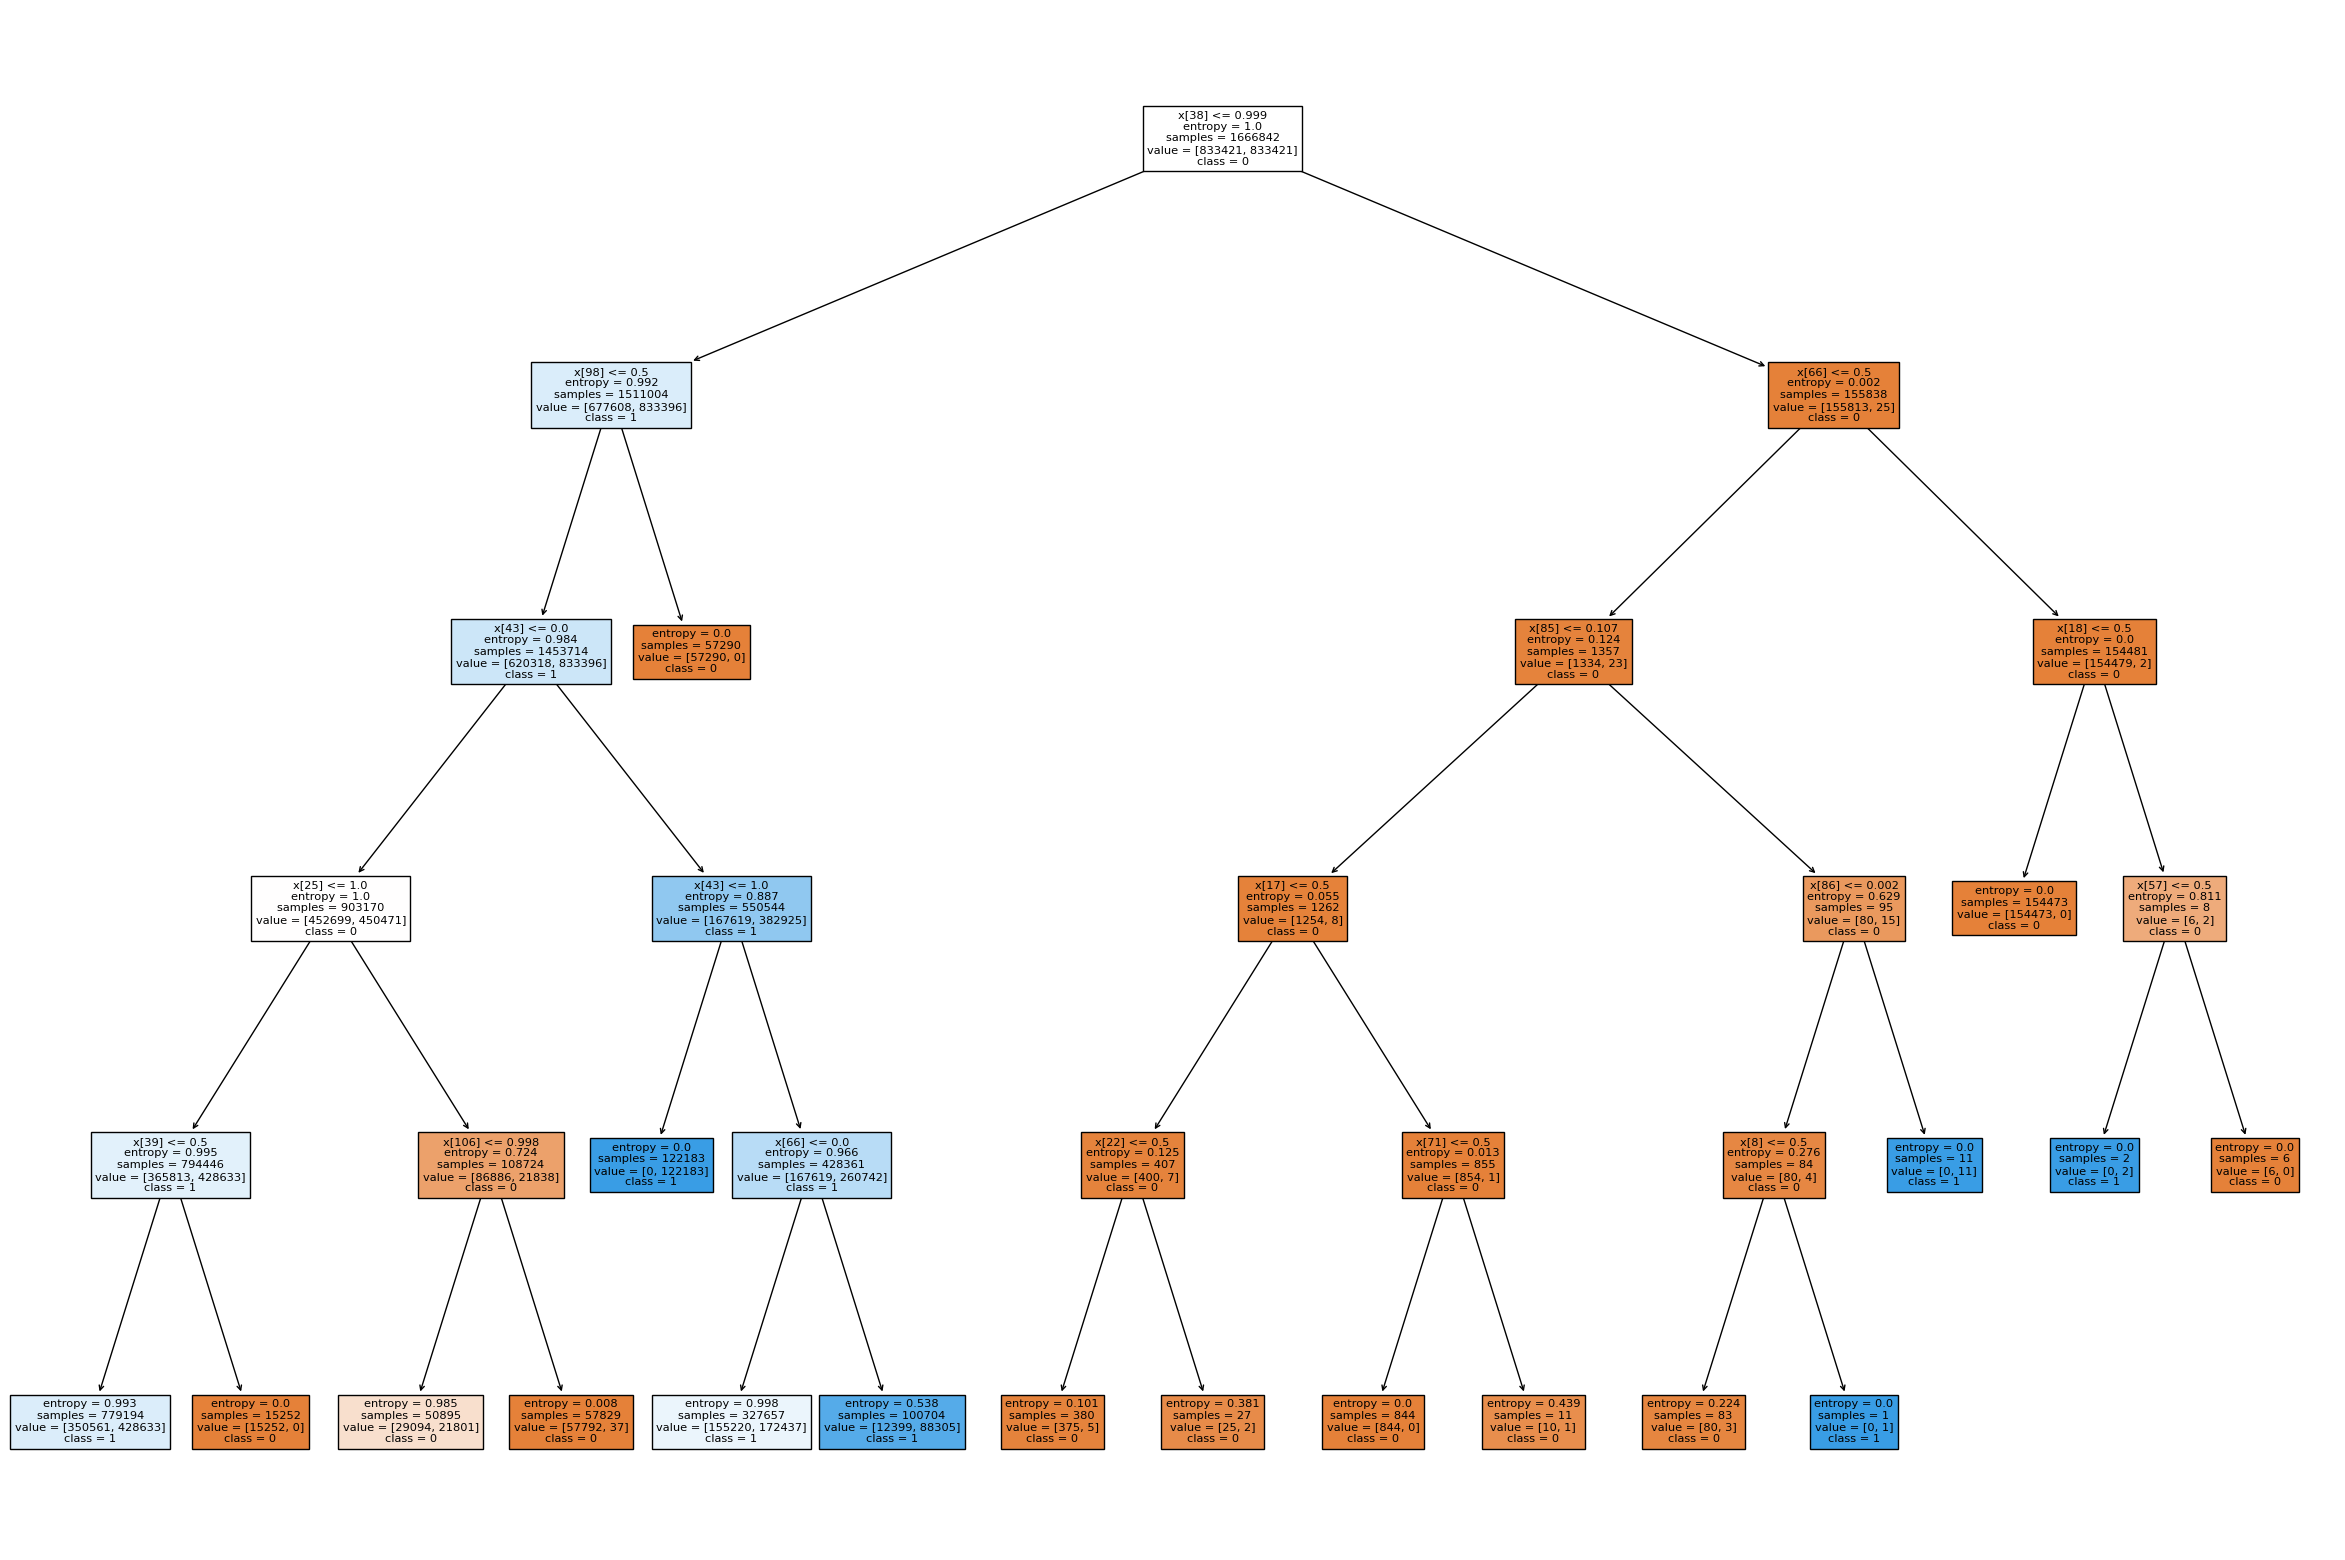

In [1313]:
# Crear un modelo de árbol de decisión
clf = DecisionTreeClassifier(max_depth=5, random_state=42,  criterion='entropy')

# Entrenar el modelo con los datos de entrenamiento
clf.fit(x_tr_resample,y_tr_resample)

# Predecir las etiquetas para los datos de prueba
preds = clf.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# Visualizar árbol de decisión
plt.figure(figsize=(30,20))
plot_tree(clf, class_names=['0','1'], filled=True)

# Guardar la figura como imagen JPEG de alta resolución
plt.savefig('arbol_decisionJP.jpg', dpi=300, bbox_inches='tight')

# Mostrar la figura
plt.show()



